# GRCh38 DNase 12 kb CAE Architecture Search 1

**Tasks:** Find the best CAE infrastructure

**Insights:**

- 

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The base directory is one level up
base = '..'
name = 'cnn-search'
dataset = 'cnn-search'
settings_filepath = '../settings-grch38-dnase-12kb.json'
search_filepath = '../{}.json'.format(name)

with open(settings_filepath, "r") as f:
    settings = json.load(f)

with open(search_filepath, "r") as f:
    optimizer_search = json.load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create training jobs

In [2]:
from jobs import jobs

jobs(
    os.path.relpath(search_filepath, base),
    os.path.relpath(settings_filepath, base),
    dataset=dataset,
    name=name,
    cluster="seas",
    epochs=25,
    batch_size=1024,
    base=base,
    clear=True,
    verbose=False
)


Created slurm file for training 144 neural networks


## Test training run of the most complex CAE

In [ ]:
from train import train_on_single_dataset

model_name = 'cf-64-128-256--ck-7-5-3--du-1024-512-256-64-32--do-0.1-0.1-0.1-0.1-0.1-0.1-0.1-0.1--e-6--rl-0.001--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-'

with open('../models/{}.json'.format(model_name), 'r') as f:
    definition = json.load(f)

train_on_single_dataset(
    settings,
    'cnn-search',
    definition,
    epochs=2,
    batch_size=256,
    peak_weight=2,
    signal_weighting='logn',
    signal_weighting_zero_point_percentage=0.02,
    base=base,
    clear=True,
)

## Create evaluation jobs

In [17]:
from evaluate import create_jobs

create_jobs(
    name,
    name=name,
    dataset=dataset,
    cluster='seas',
    base=base,
    clear=True,
    incl_dtw=False,
)

Created slurm file for evaluating 116 neural networks


In a terminal run: `sbatch evaluate-cnn-search-2.slurm`

In [4]:
from ae.utils import check_status

okay, not_found, outdated = check_status(
    name, 'training', 'cnn-search', base=base
)

if okay:
    print('Trainings completed')
else:
    print('Trainings did not finish. Missing {}'.format(len(not_found)))

Trainings completed


## Compare

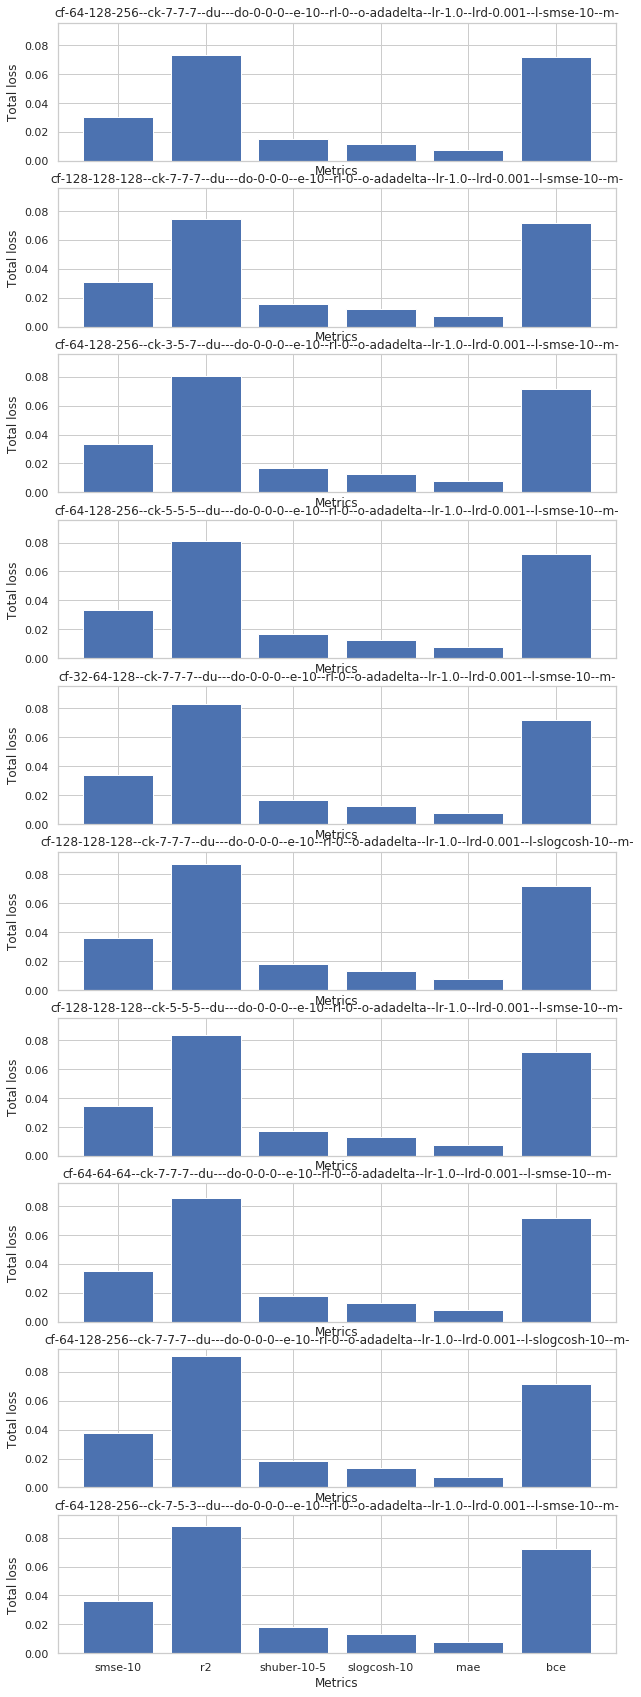

In [5]:
from compare import compare
    
performance = compare(
    'definitions-{}.json'.format(name),
    dataset_name=dataset,
    base=base,
    clear=False,
    verbose=False,
    silent=False,
    remove_common_prefix_from_df=True,
)

In [7]:
import qgrid

qgw = qgrid.show_grid(performance)
qgw

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

64-128-256--ck-7-7-7--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


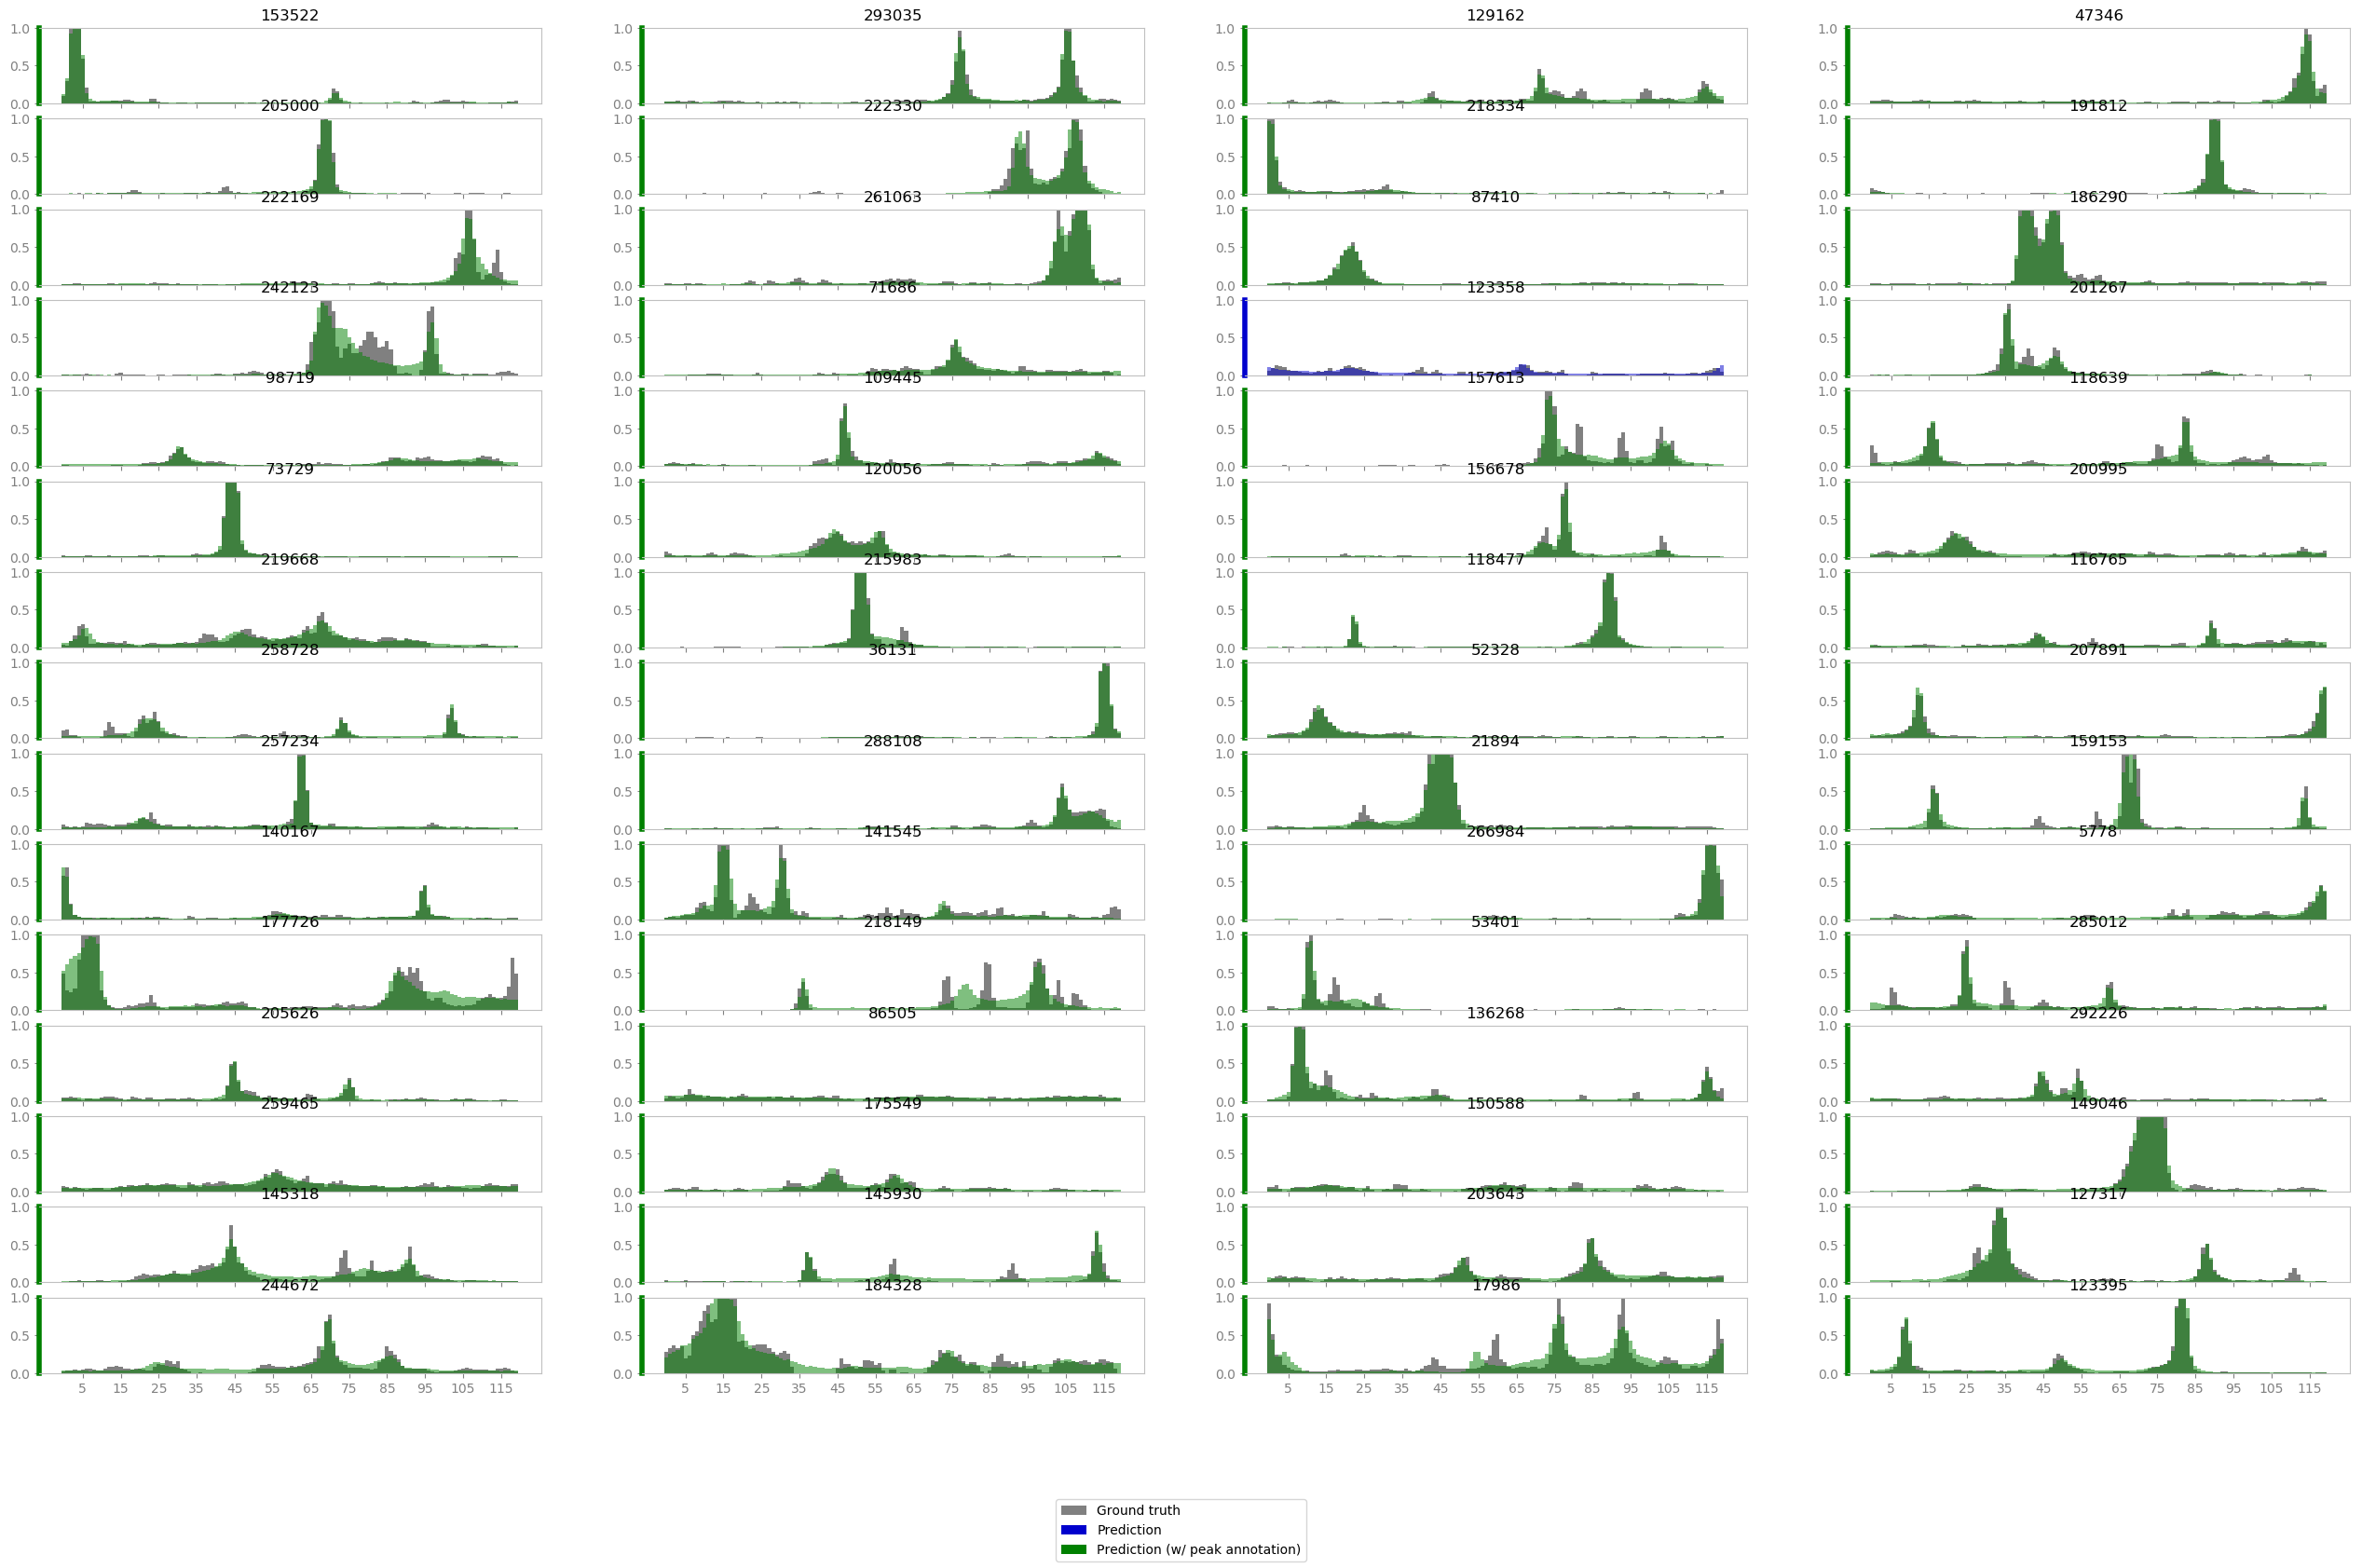

128-128-128--ck-7-7-7--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


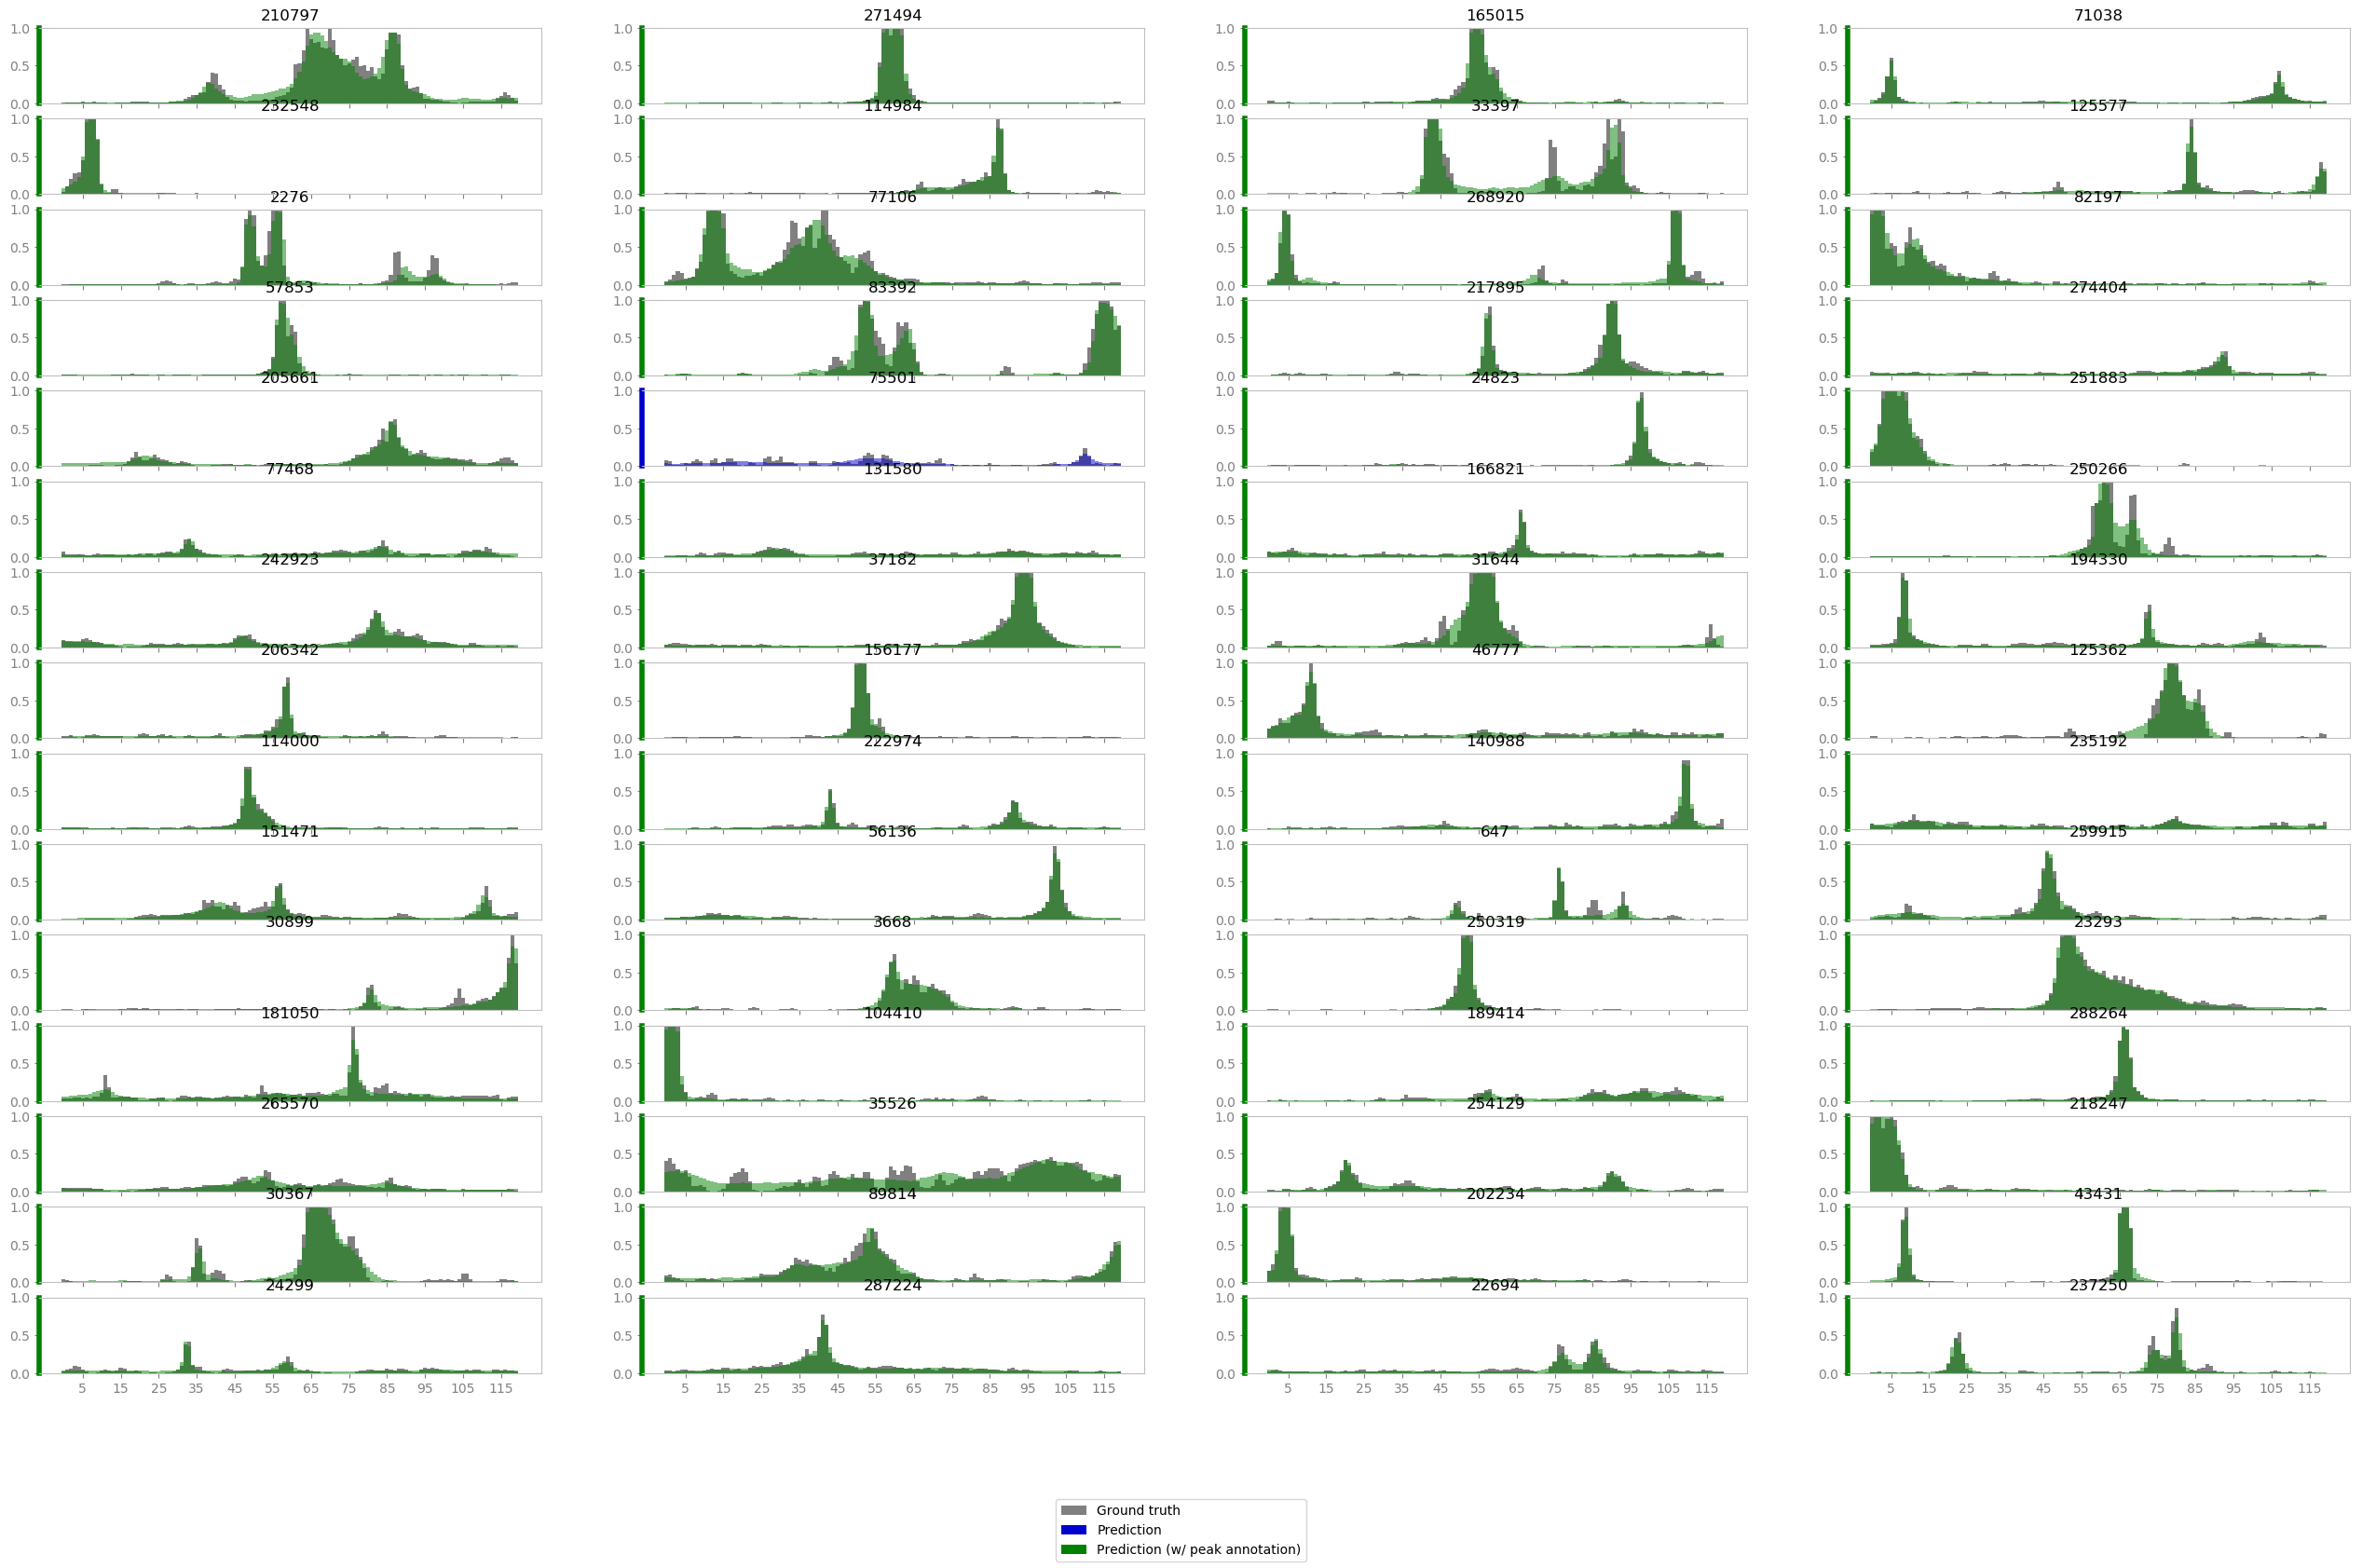

64-128-256--ck-3-5-7--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


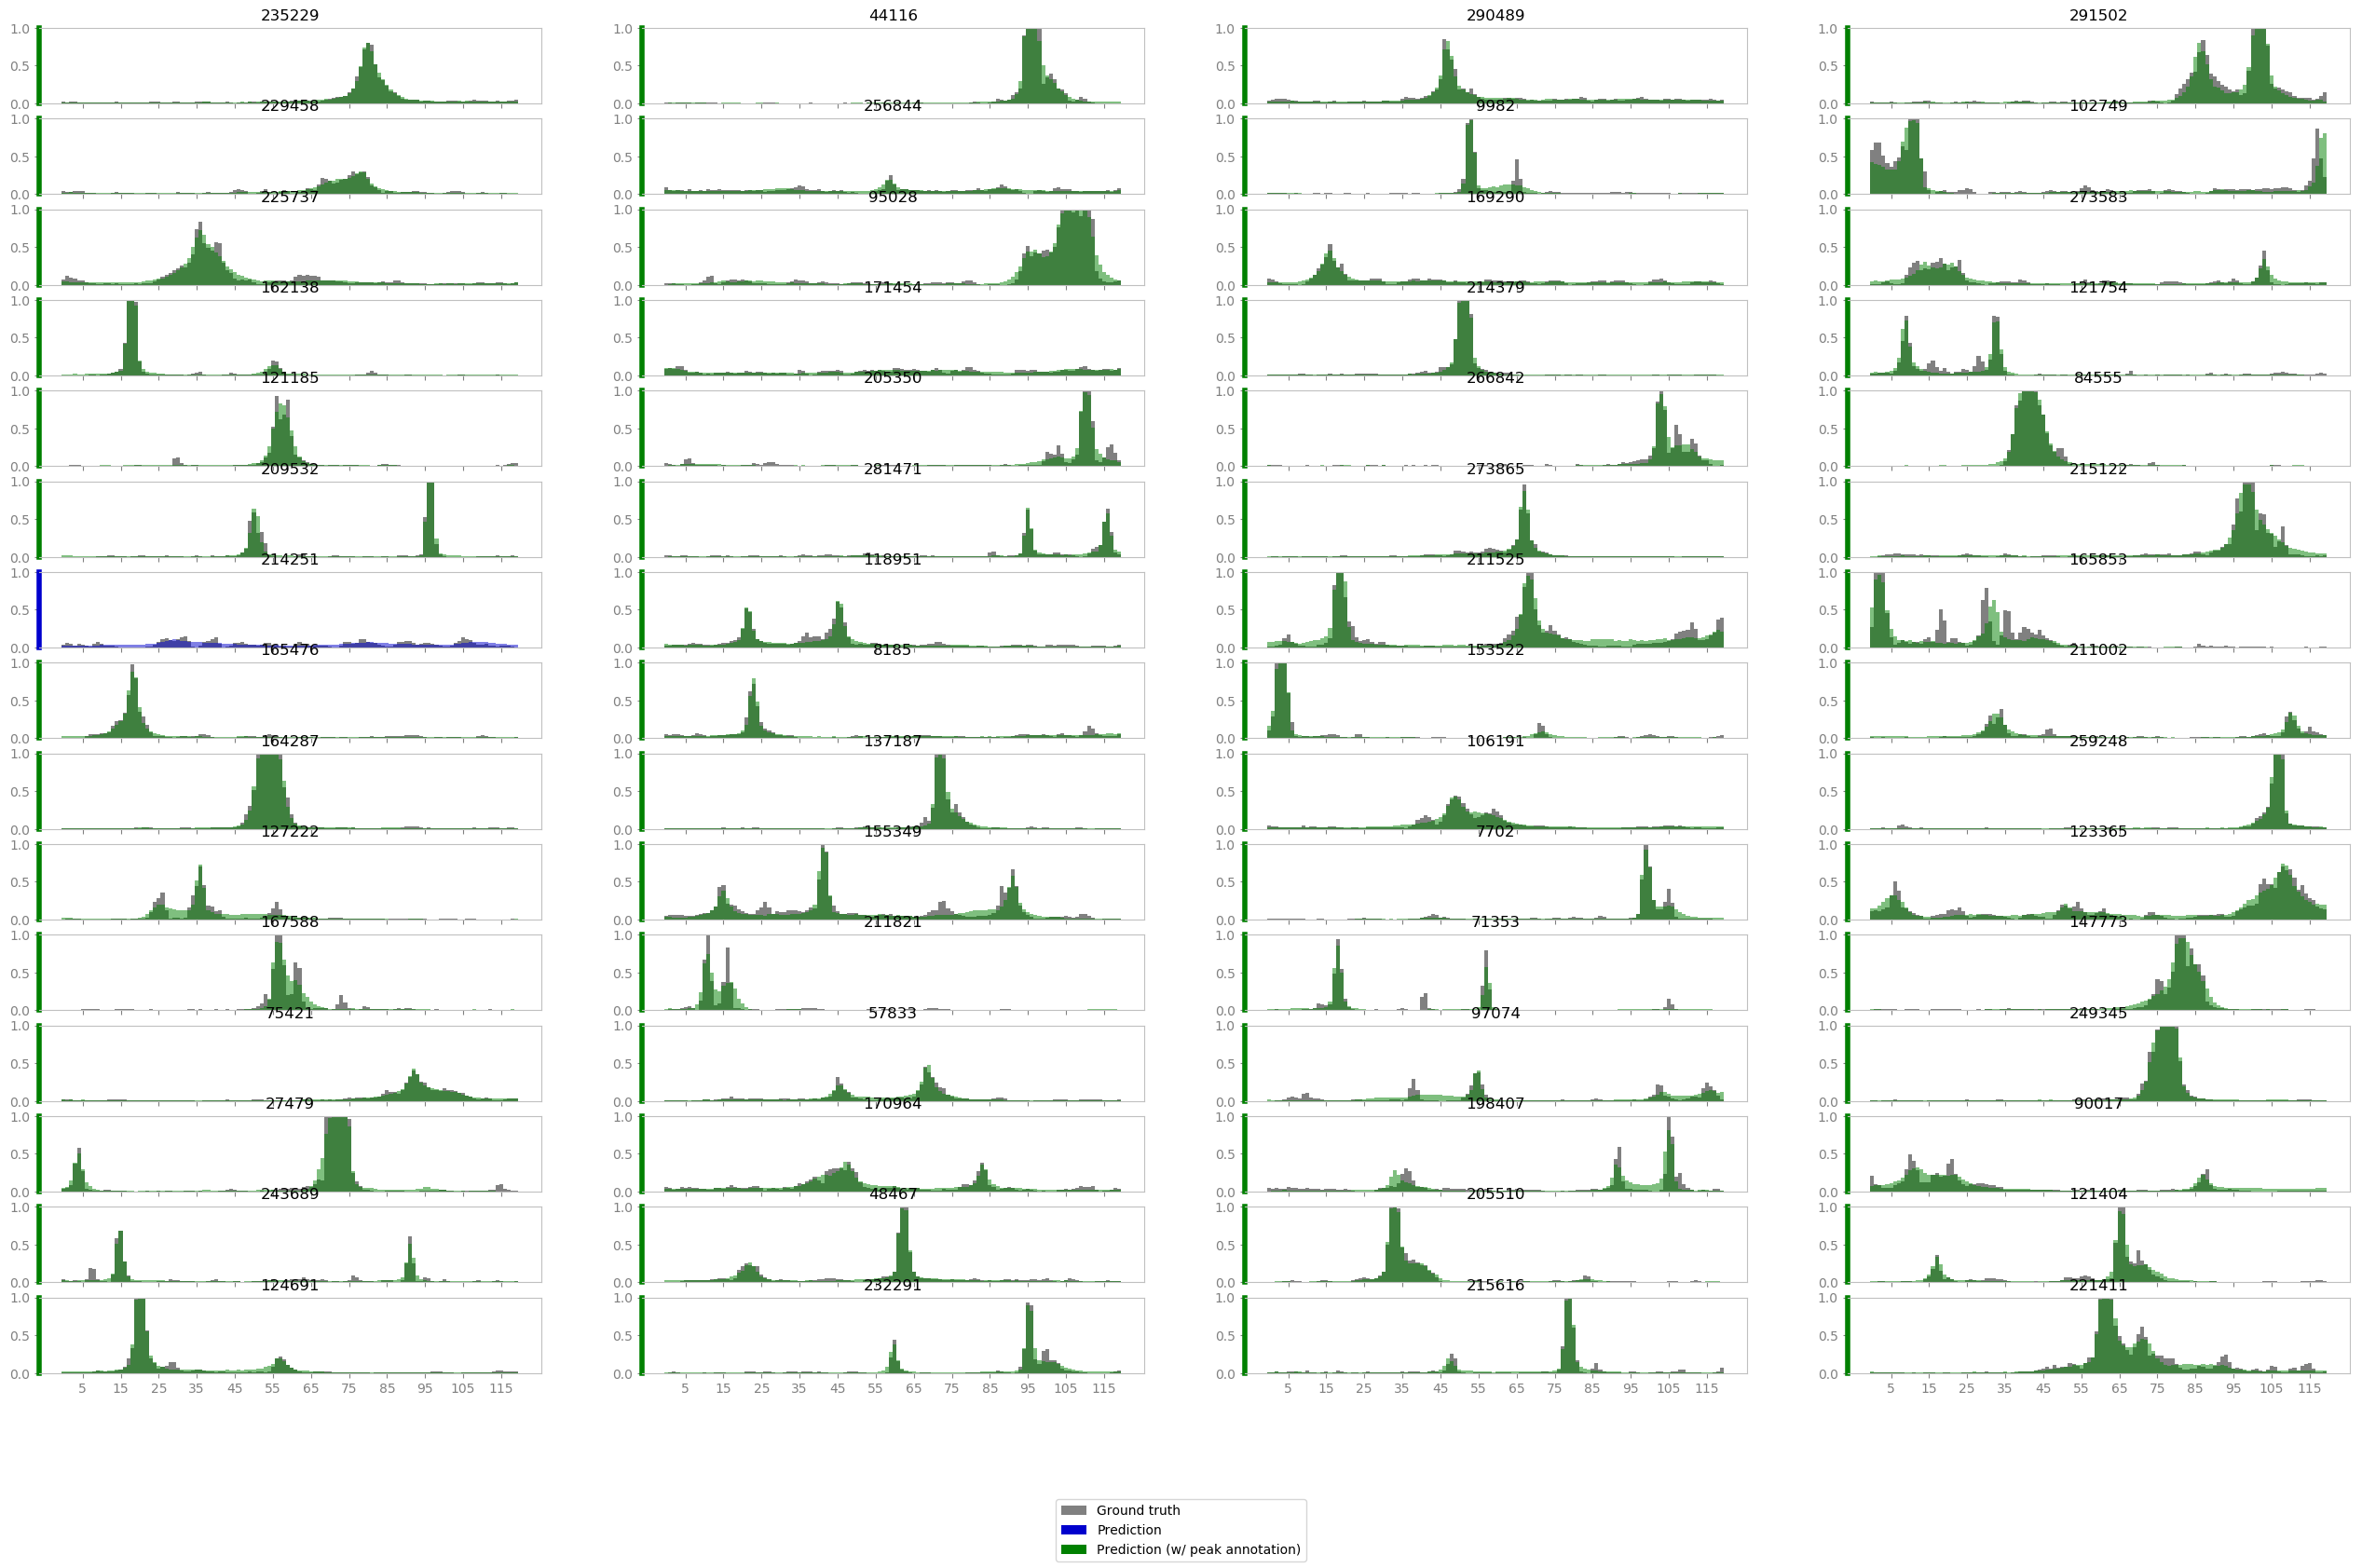

64-128-256--ck-5-5-5--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


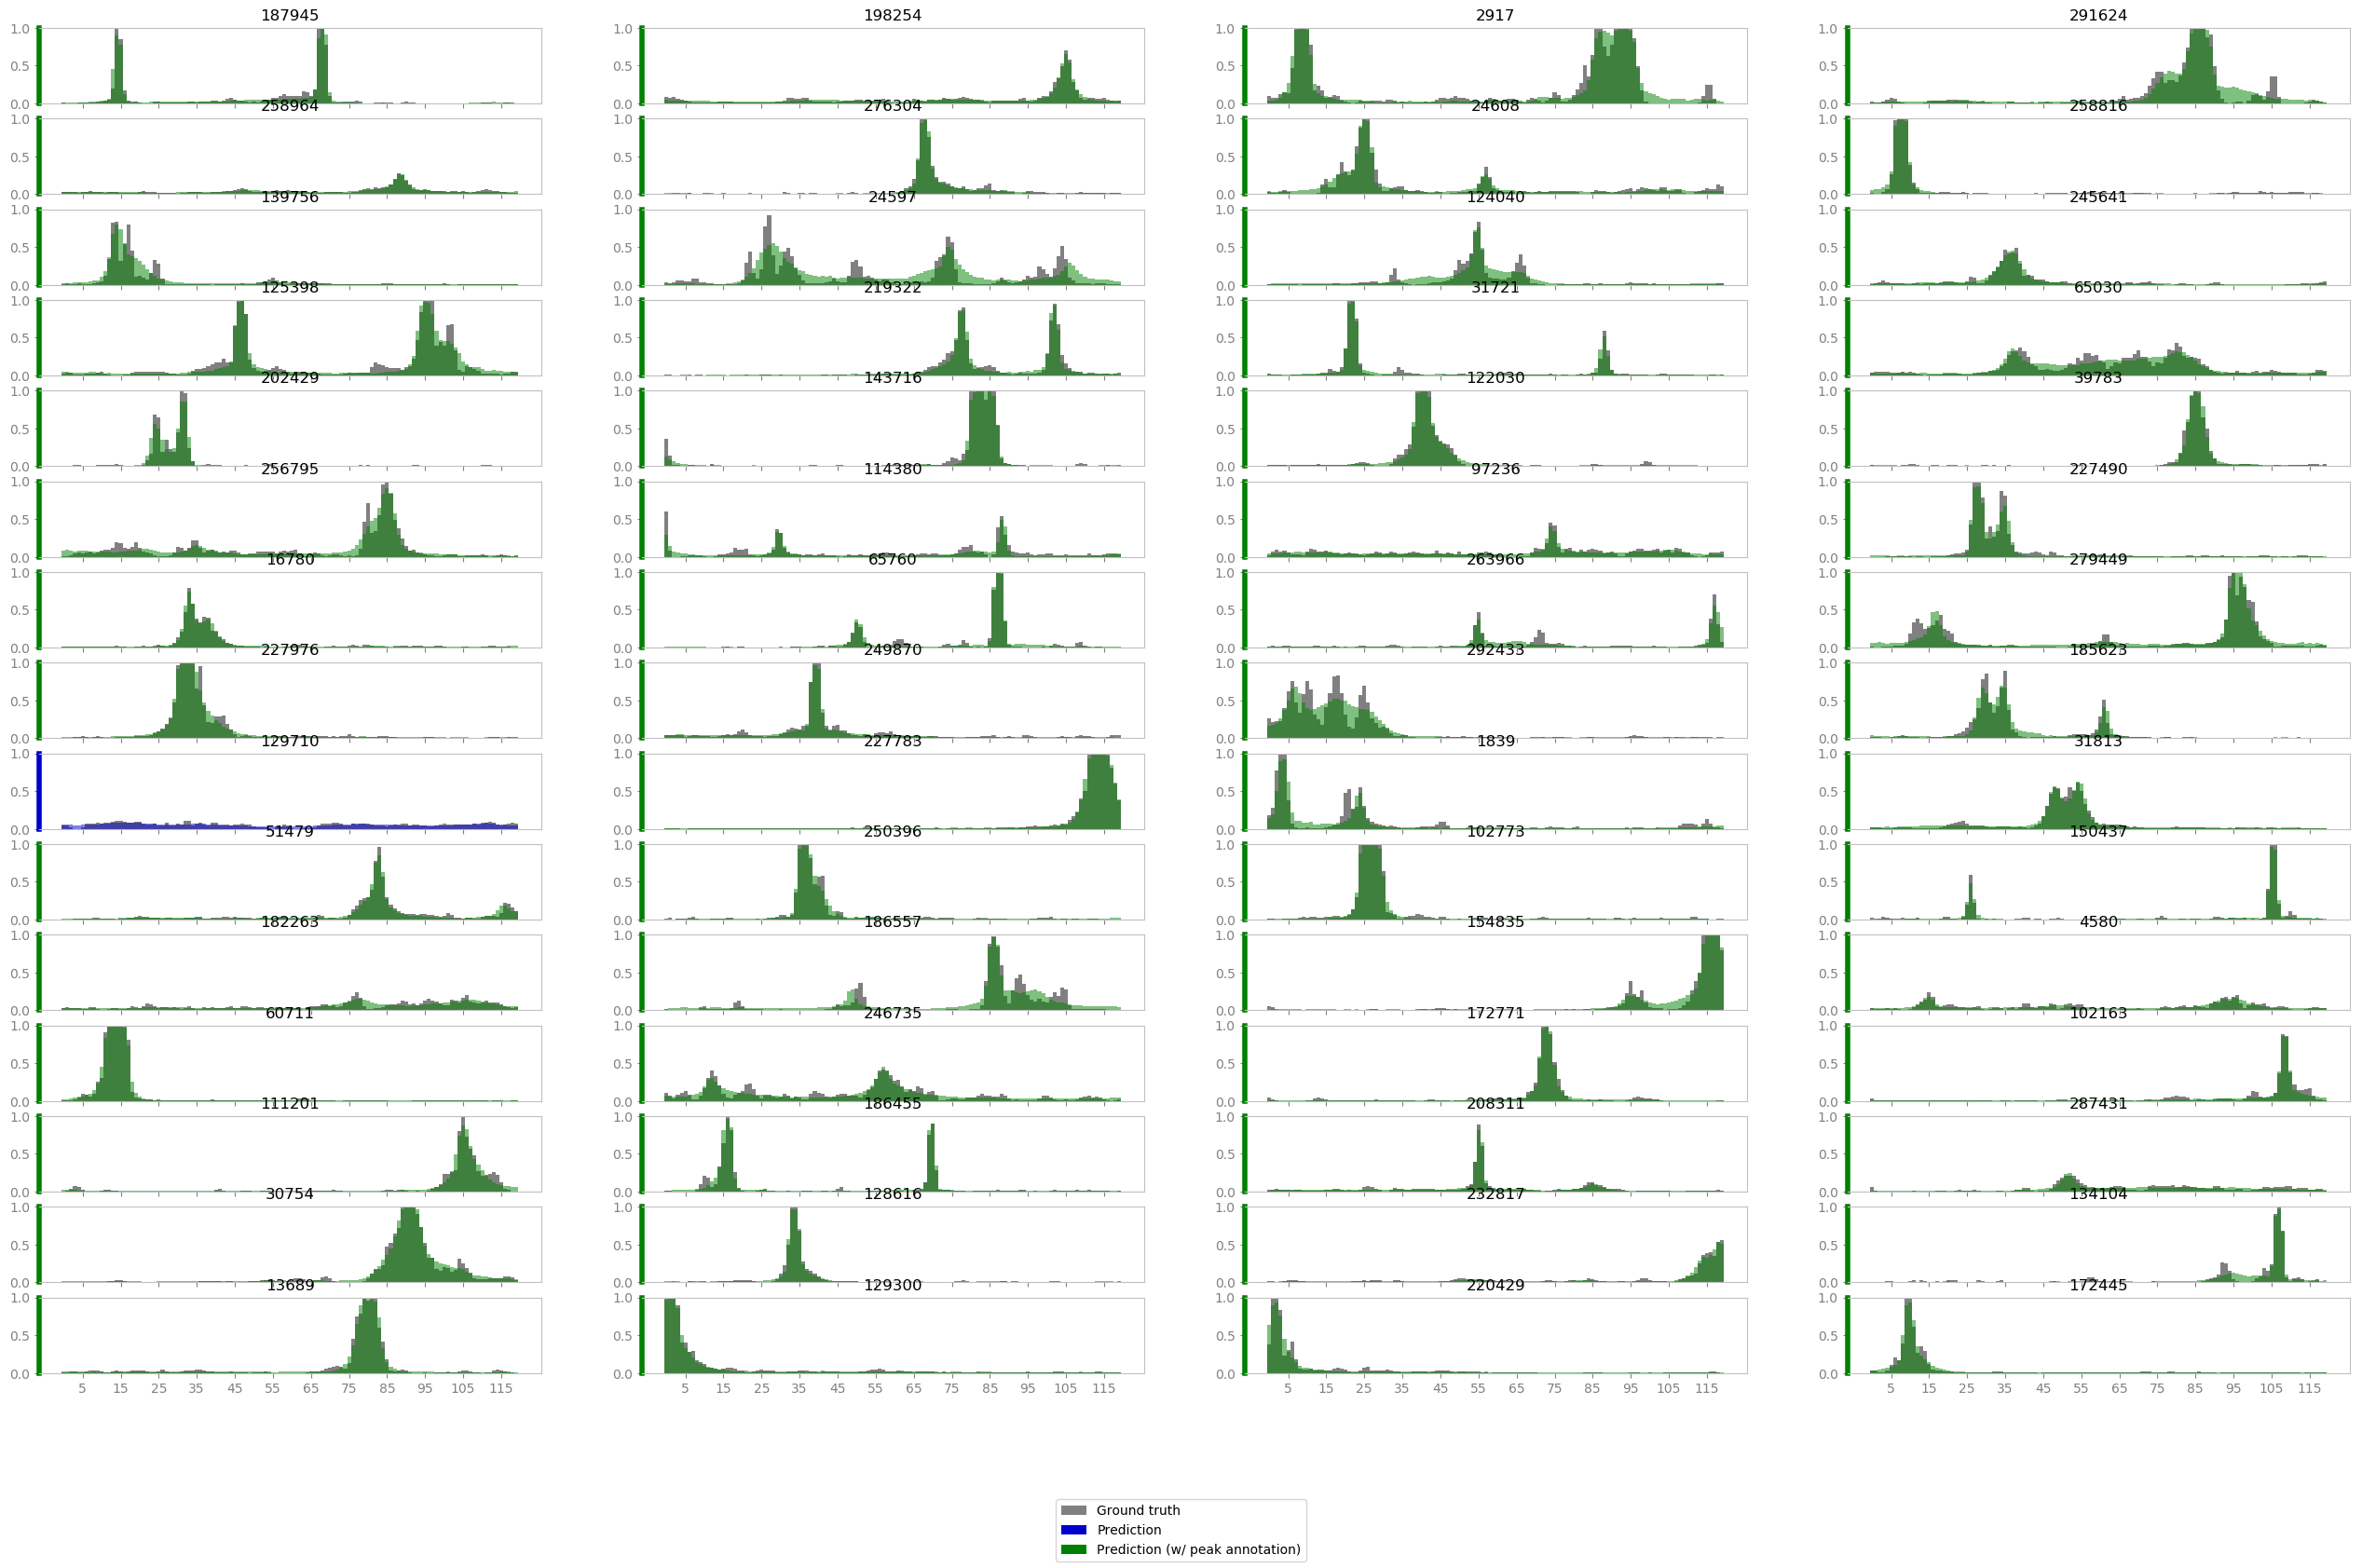

32-64-128--ck-7-7-7--du---do-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-smse-10--m-


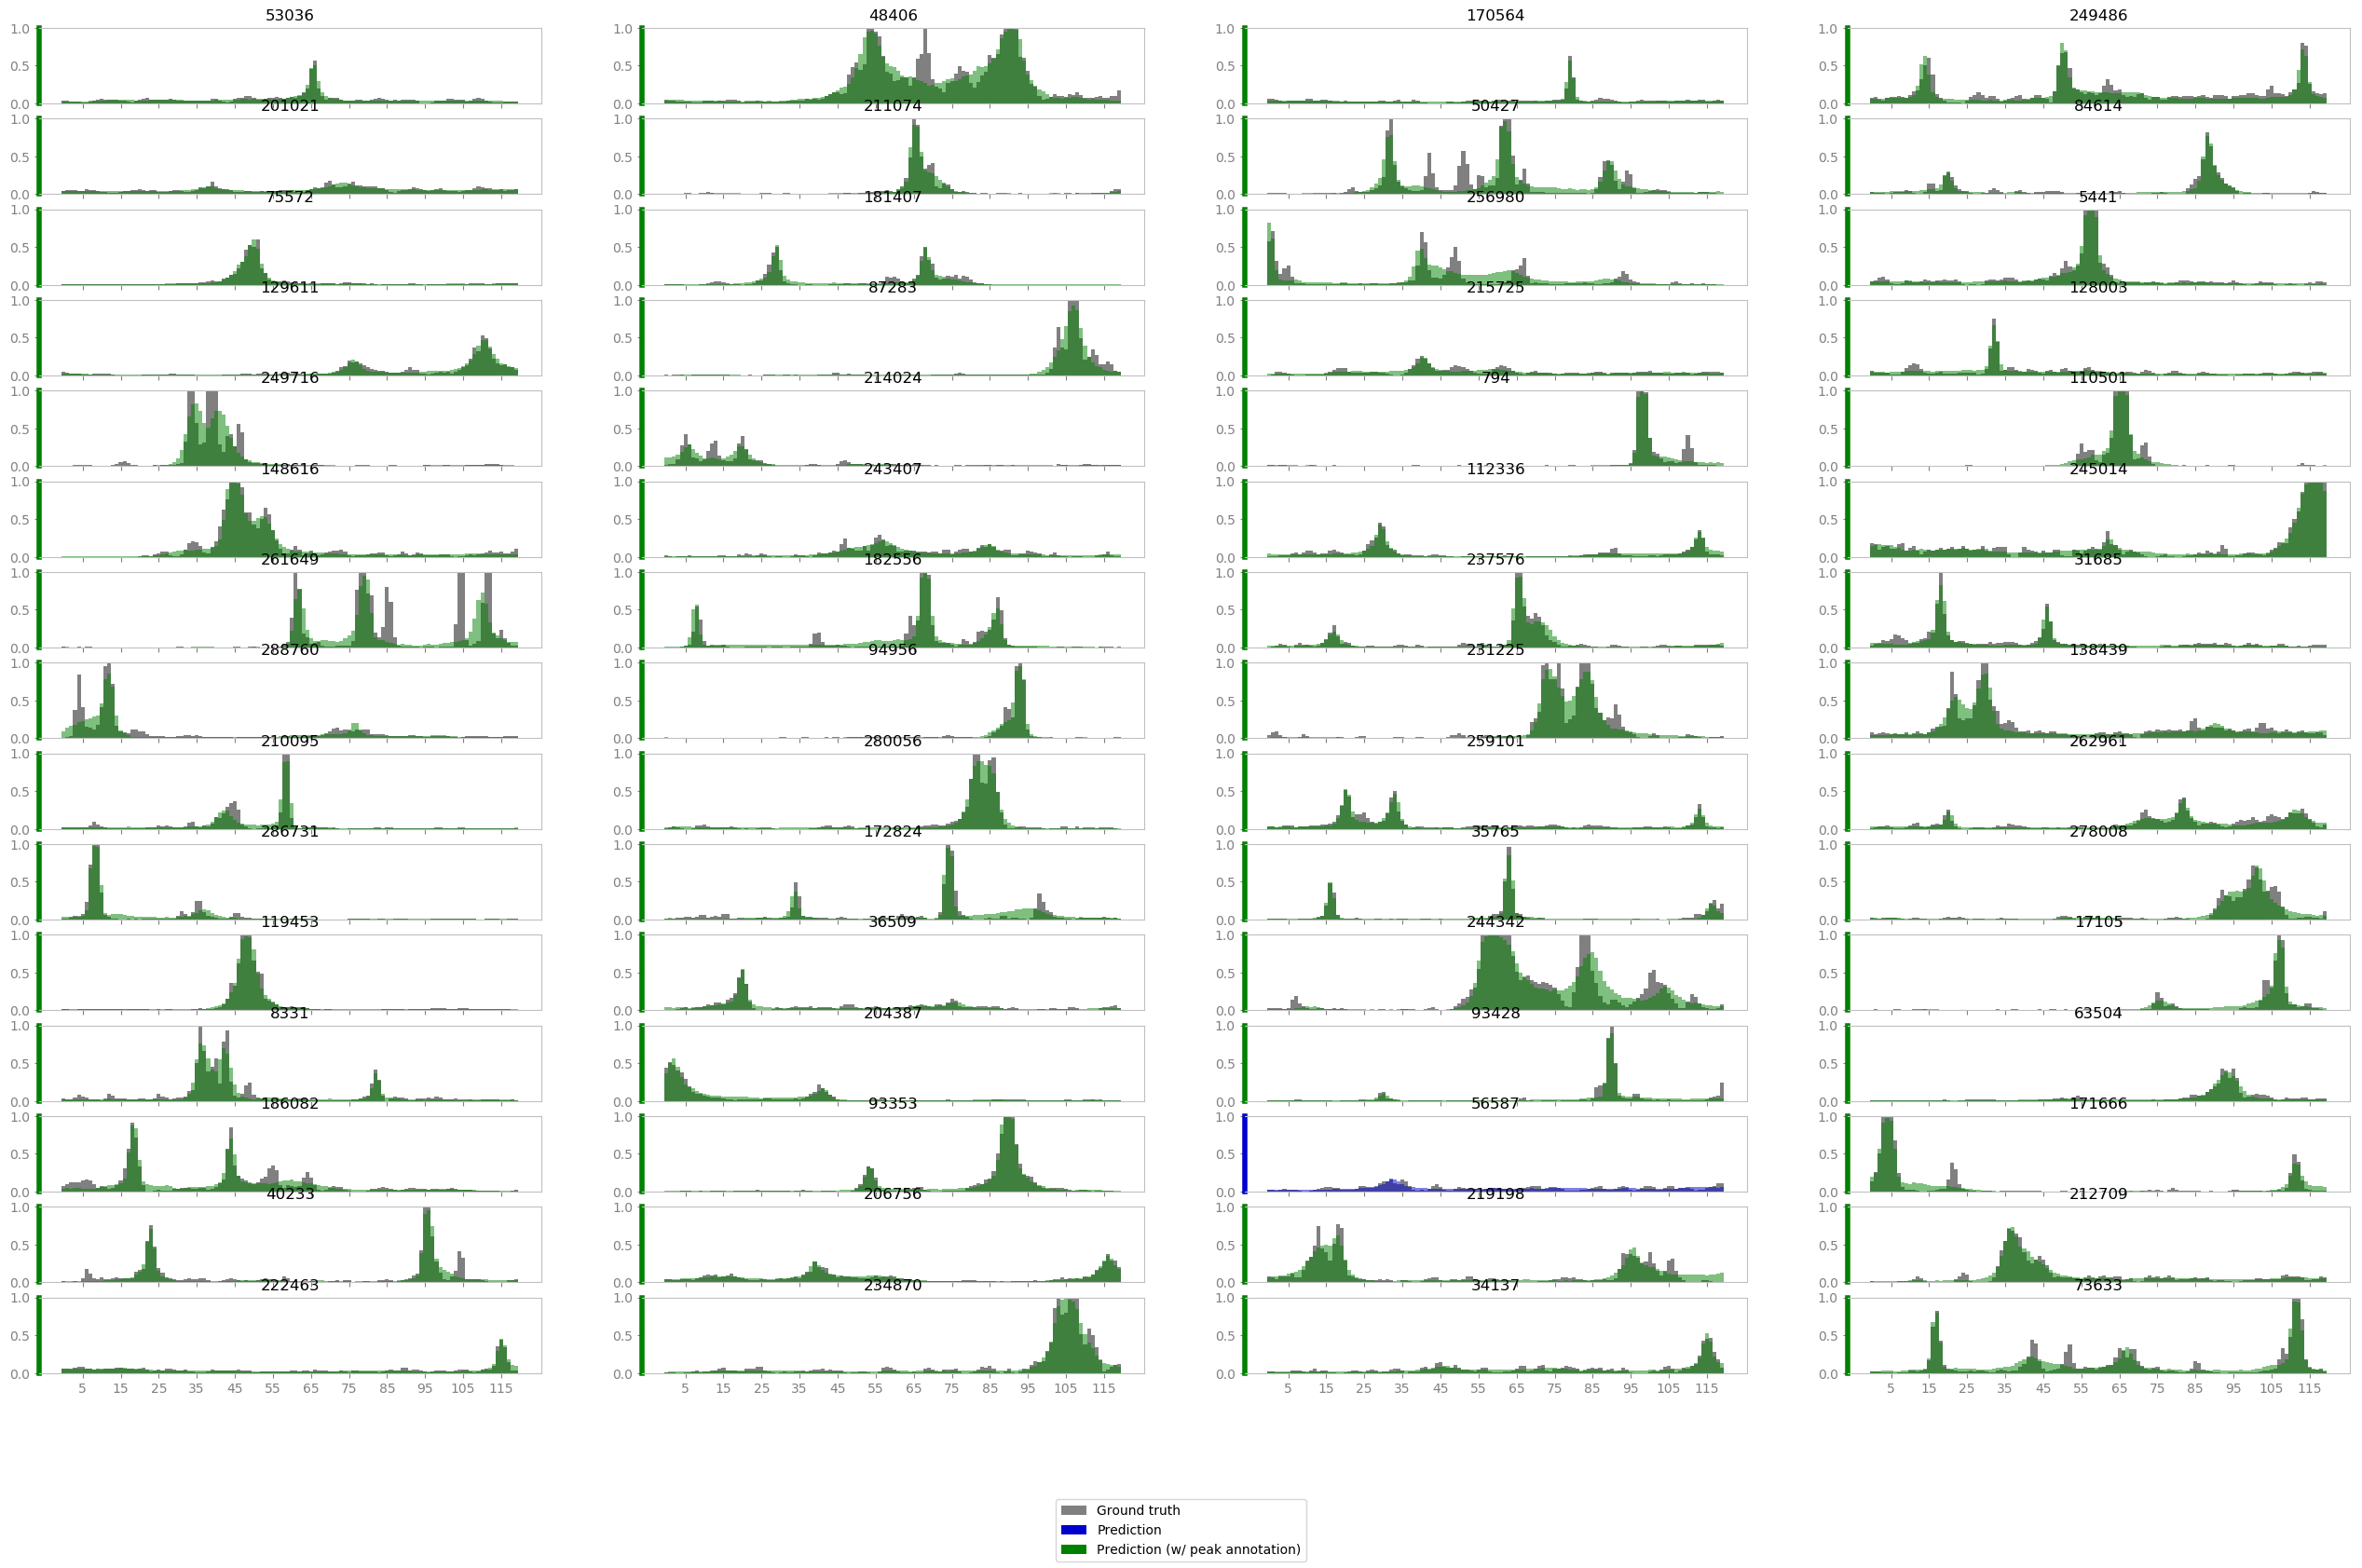

In [8]:
from IPython.core.display import Image, display

for model in qgw.get_selected_df().iterrows():
    print(model[0])
    display(Image(os.path.join(base, 'models', 'cf-{}---predictions-{}.png'.format(model[0], 'cnn-search'))))